In [1]:
import rockpool
print(f'Rockpool version {rockpool.__version__}')

import samna
print(f'Samna version {samna.__version__}')

# from rockpool.devices.xylo.syns63300 import mapper
from rockpool.devices.xylo.syns65302 import XyloSamna, config_from_specification, mapper, XyloSim
from rockpool.devices.xylo.syns65302 import xylo_a3_devkit_utils as hdkutils

from rockpool.devices.xylo import find_xylo_hdks

from rockpool.transform.quantize_methods import channel_quantize

from rockpool.nn.modules import LIF, Linear
from rockpool.nn.combinators import Sequential

import numpy as np
import matplotlib.pyplot as plt

import time
import warnings

from tqdm.autonotebook import tqdm

/usr/lib/python3/dist-packages/pythran/tables.py:4520: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, method):
/usr/lib/python3/dist-packages/pythran/tables.py:4553: FutureWarning: In the future `np.bytes` will be defined as the corresponding NumPy scalar.
  obj = getattr(themodule, elem)


Rockpool version 2.7.dev
Samna version 0.37.10.31+g52e7582d3.dirty


WARNING    /home/vleite/Software/rockpool/rockpool/devices/xylo/syns61201/xylo_samna.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
 [py.warnings]
  from tqdm.autonotebook import tqdm



from samna.xyloA3.configuration import InputInterfaceConfig


In [2]:
hdks, modules, versions = find_xylo_hdks()

for version, xylo in zip(versions, hdks):
    if version == "syns65302":
        xa3_node = xylo

The connected Xylo HDK contains a Xylo A3. Importing `rockpool.devices.xylo.syns65302`
size of hidden neuron count 1
size of output neuron count 1


In [3]:
net = Sequential(
    Linear((16, 63)),
    LIF((63, 63)),

    Linear((63, 32)),
    LIF(32),
)
net

ModSequential  with shape (16, 32) {
    Linear '0_Linear' with shape (16, 63)
    LIF '1_LIF' with shape (63, 63)
    Linear '2_Linear' with shape (63, 32)
    LIF '3_LIF' with shape (32, 32)
}

In [4]:
net[0].weight *= 0.05

In [5]:
spec = mapper(net.as_graph())
Q_spec = spec
Q_spec.update(channel_quantize(**Q_spec))

# Q_spec['weights_in'] = np.expand_dims(Q_spec['weights_in'], -1)
# Q_spec['weights_rec'] = np.expand_dims(Q_spec['weights_rec'], -1)

config, is_valid, msg = config_from_specification(**Q_spec)

if not is_valid:
    print(msg)

WARNING    /home/vleite/Software/rockpool/rockpool/devices/xylo/syns65302/xylo_mapper.py:56: DRCWarning: Xylo-A3 only supports up to 16 output channels. The network requires 32 output channels.
  warnings.warn(
 [py.warnings]
  warnings.warn(



In [6]:
# - Encode a PDM input chirp
from rockpool.devices.xylo.syns65302 import AFESimPDM

from scipy.signal import chirp

pdm_sr = 1562500.0
net_dt = 1024e-6
audio_sr = 48e3

afesim_pdm = AFESimPDM.from_specification(
    select_filters=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
    spike_gen_mode="divisive_norm",
    rate_scale_factor=63,
    low_pass_averaging_window=84e-3,
    dn_EPS=1,
    fixed_threshold_vec=None,
    dt=net_dt,
)

T = 10000
times = np.arange(0, T) / audio_sr
signal = chirp(times, 1, T/audio_sr, 100, phi = 90)

__scale = 0.8
out_pdm, state_pdm, rec_pdm = afesim_pdm((signal * __scale, audio_sr))

WARNING    /home/vleite/Software/rockpool/rockpool/devices/xylo/syns65302/afe/pdm/microphone_pdm.py:133: UserWarning: 

+++++++++++++++++++++++++++++++++++++++++++++++++++++++ warnings +++++++++++++++++++++++++++++++++++++++++++++++++++++++
In practice, the input to the PDM microphone (fed by a clock of rate:1562500.0) is the analog audio signal.
In simulations, however, we have to use sampled audio signal at the input to mimic this analog signal.
Here we resample the input audio (of course artificially) to the higher sample rate of PDM microphone (1562500.0).
For a more realistic simulation, it is better to provide an audio signal which is originally sampled with a higher rate.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


  warnings.warn(
 [py.warnings]

+++++++++++++++++++++++++++++++++++++++++++++++++++++++ warnings +++++++++++++++++++++++++++++++++++++++++++++++++++++++
In practice, the input to the PDM m

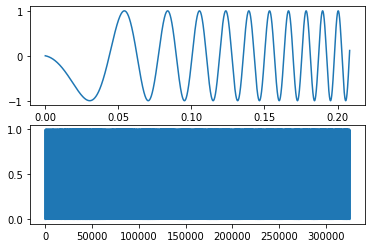

In [7]:
plt.subplot(2, 1, 1)
plt.plot(times, signal)
plt.subplot(2, 1, 2)
plt.plot((rec_pdm['0_PDMADC']['0_MicrophonePDM_output'] + 1) / 2)

In [8]:
read_buffer = hdkutils.new_xylo_read_buffer(xa3_node)
write_buffer = hdkutils.new_xylo_write_buffer(xa3_node)

# - Trial PDM interface
hdkutils.initialise_xylo_hdk(xa3_node)
hdkutils.fpga_enable_pdm_interface(xa3_node)

hdkutils.fpga_pdm_clk_enable(xa3_node)

In [9]:
# - Configure XA3
hdkutils.apply_configuration(xa3_node, config)

input = (rec_pdm['0_PDMADC']['0_MicrophonePDM_output'] + 1) / 2

dt = net_dt

# - Calculate sample rates and `dt`-length window
PDM_sample_rate = 1562500
PDM_samples_per_dt = PDM_sample_rate * dt

# - Check window length, should be integer
if not np.allclose(PDM_samples_per_dt % 1, 0.0):
    warnings.warn(
        f"Non-integer number of PDM samples per network `dt`. Network evolution will not be accurate. PDM_samples_per_dt: {PDM_samples_per_dt}; PDM_sample_rate: {PDM_sample_rate} Hz."
    )
PDM_samples_per_dt = int(PDM_samples_per_dt)

# - Compute number of `dt` time-steps
num_dt = np.size(input) // PDM_samples_per_dt

# - Check input length
if np.size(input) % PDM_samples_per_dt > 0:
    warnings.warn(
        f"Input PDM audio trace does not fit evenly into `dt`. Audio will be trimmed at the end of the sample. input size: {np.size(input)}; PDM_samples_per_dt: {PDM_samples_per_dt}."
    )

# - Bin samples into `dt`-length windows and trim
input_raster = np.reshape(
    input[: num_dt * PDM_samples_per_dt], [-1, PDM_samples_per_dt]
)

read_timeout = 5.
Nin, Nhidden, Nout = (16, 63, 32)
record = True

# - Initialise lists for recording state
vmem_ts = []
isyn_ts = []
isyn2_ts = []
vmem_out_ts = []
isyn_out_ts = []
spikes_ts = []
output_ts = []

# - Send PDM data and extract activity
for input_sample in tqdm(input_raster):
    # - Send PDM events for this dt
    pdm_events = [samna.xyloAudio3.event.AfeSample(data = int(i)) for i in input_sample]
    write_buffer.write(pdm_events)
    time.sleep(.5)

    hdkutils.read_input_spikes(read_buffer, write_buffer)

    # - Trigger processing
    hdkutils.advance_time_step(write_buffer)

    # - Wait until xylo has finished the simulation of this time step
    t_start = time.time()
    is_timeout = False
    while not hdkutils.is_xylo_ready(read_buffer, write_buffer):
        if time.time() - t_start > read_timeout:
            is_timeout = True
            break

    if is_timeout:
        raise TimeoutError

    # - Read all synapse and neuron states for this time step
    if record:
        this_state = hdkutils.read_neuron_synapse_state(
            read_buffer, write_buffer, Nin, Nhidden, Nout
        )
        vmem_ts.append(this_state.V_mem_hid)
        isyn_ts.append(this_state.I_syn_hid)
        isyn2_ts.append(this_state.I_syn2_hid)
        vmem_out_ts.append(this_state.V_mem_out)
        isyn_out_ts.append(this_state.I_syn_out)
        spikes_ts.append(this_state.Spikes_hid)

    # - Read the output event register
    output_events = hdkutils.read_output_events(
        read_buffer, write_buffer
    )[:Nout]
    output_ts.append(output_events)


WARNING    /tmp/ipykernel_86470/1573868565.py:24: UserWarning: Input PDM audio trace does not fit evenly into `dt`. Audio will be trimmed at the end of the sample. input size: 325489; PDM_samples_per_dt: 1600.
  warnings.warn(
 [py.warnings]
  warnings.warn(



size of hidden neuron count 63
size of output neuron count 32


  0%|          | 0/203 [00:00<?, ?it/s]

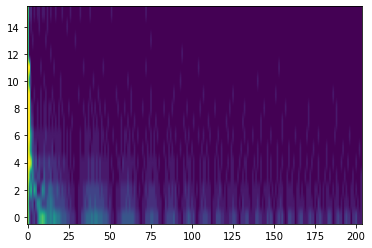

In [10]:
plt.imshow(rec_pdm['3_Raster_output'].T, aspect='auto', origin='lower')